In [2]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson
from scipy.stats import chi2

In [4]:
pd.set_option('mode.chained_assignment', None, 'display.float_format', lambda x: '%.2f' % x)
pd.options.mode.copy_on_write = True

In [6]:
print(f'Current working directory is {os.getcwd()}')

Current working directory is C:\Users\cavin\Documents\NSS_Projects\ACCR-project-clj\accre-carbonara\notebooks


In [8]:
reg_df = pd.read_csv('../data/reg_df.csv')

In [10]:
reg_df['time'] = pd.to_datetime(reg_df['time'])

In [12]:
reg_df

,time,slurm_crashes,completed_jobs,used_mem,fails
0,2020-10-01 00:10:00,0,3,363.32,0
1,2020-10-01 00:15:00,0,3,489.28,0
2,2020-10-01 00:20:00,0,9,6.23,0
3,2020-10-01 00:25:00,0,18,77.65,0
4,2020-10-01 00:30:00,0,11,6.23,0
...,...,...,...,...,...
105489,2021-10-07 20:10:00,0,1,0.09,0
105490,2021-10-07 20:15:00,0,1,0.09,0
105491,2021-10-07 20:25:00,0,1,393.07,0
105492,2021-10-07 20:30:00,0,1,0.09,0


In [14]:
reg_df[reg_df['time'] == '2020-10-18 07:45:00']

,time,slurm_crashes,completed_jobs,used_mem,fails
4987,2020-10-18 07:45:00,3,14,1417.35,1


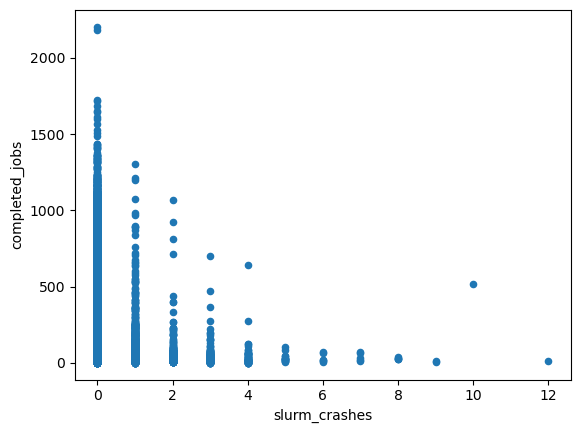

In [18]:
reg_df.plot(x='slurm_crashes', y='completed_jobs', kind='scatter');

In [22]:
model = smf.logit('fails ~ completed_jobs',
                    data = reg_df).fit()

Optimization terminated successfully.
         Current function value: 0.103913
         Iterations 8


In [24]:
model.params

Intercept        -3.80
completed_jobs   -0.00
dtype: float64

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fails   No. Observations:               105494
Model:                          Logit   Df Residuals:                   105492
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:               0.0001163
Time:                        01:17:30   Log-Likelihood:                -10962.
converged:                       True   LL-Null:                       -10963.
Covariance Type:            nonrobust   LLR p-value:                    0.1103
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.7976      0.024   -156.001      0.000      -3.845      -3.750
completed_jobs    -0.0003      0.000     -1.553      0.121      -0.001    7.38e-05
==================================================================================
"""

In [44]:
lm = smf.ols('completed_jobs ~ slurm_crashes', data = reg_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         completed_jobs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.806
Date:                Mon, 02 Dec 2024   Prob (F-statistic):            0.00909
Time:                        01:22:03   Log-Likelihood:            -6.6100e+05
No. Observations:              105494   AIC:                         1.322e+06
Df Residuals:                  105492   BIC:                         1.322e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        70.0357      0.395    177.304      0.000      69.261      70.810
slurm_crashes    -4.0223      1.542     -2.609      0.009      -7.044      -1.000
==============================================================================
Omnibus:                   104642.806   Durbin-Watson:                   0.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4980788.899
Skew:                           5.013   Prob(JB):                         0.00
Kurtosis:                      35.134   Cond. No.                         3.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

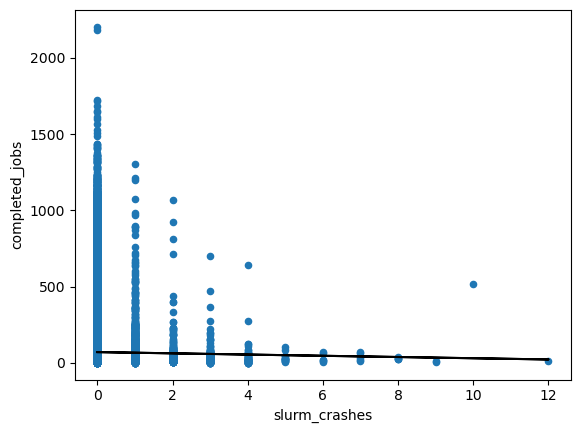

In [48]:
reg_df.plot(x = 'slurm_crashes', y = 'completed_jobs', kind = 'scatter')
plt.plot(reg_df['slurm_crashes'], lm.fittedvalues, color = 'black');

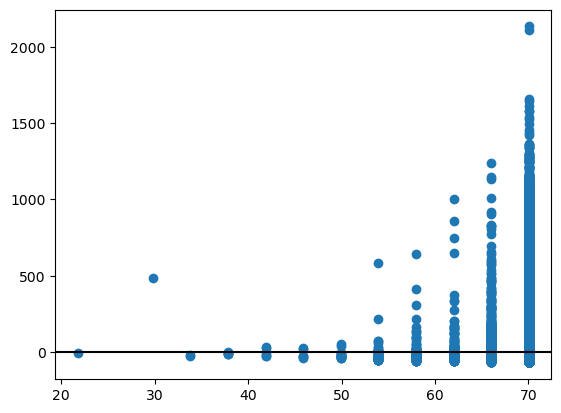

In [36]:
plt.scatter(lm.fittedvalues, lm.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'black')
plt.xlim(xmin, xmax);

In [56]:
reg_df['rolling'] = reg_df.rolling(7)['slurm_crashes'].sum()

In [58]:
new_lm = smf.ols('completed_jobs ~ rolling', data = reg_df).fit()

In [60]:
reg_df['gage_shifted'] = reg_df['completed_jobs'].shift(periods = 1)

In [62]:
shift_lm = smf.ols('completed_jobs ~ gage_shifted', data = reg_df).fit()

In [64]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
slurm_crashes,1.00,110357.55,110357.55,6.81,0.01
Residual,105492.00,1710577663.67,16215.24,NaN,NaN


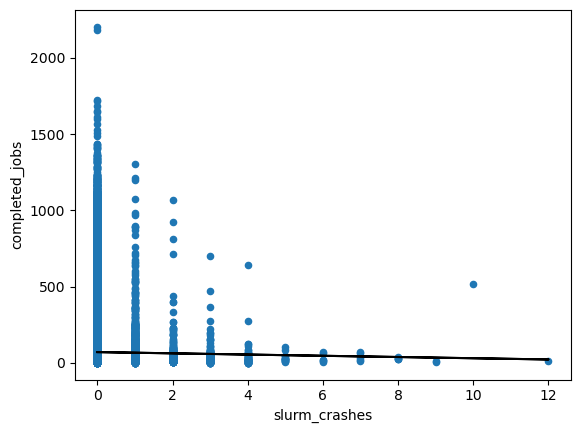

In [66]:
filtered_reg_df = reg_df.iloc[:len(lm.fittedvalues)]

filtered_reg_df.plot(x='slurm_crashes', y='completed_jobs', kind='scatter')
plt.plot(filtered_reg_df['slurm_crashes'], lm.fittedvalues, color='black')